# Netflow Parallel Library Usage

- For installation details refer to netflow/readme.txt.
- Run 'make all' in netflow/ directory first.

## Flow Simulation
We begin by loading the base network into memory and calling the solve_flow_inout() function to simulate network flow.

The chosen dynamic viscosity is $\mu = 10^{-3}$ Pa s. The pressure prescribed at inlet and outlet pores are $p_{\mathrm{in}} = 10^4$ Pa, and $p_{\mathrm{out}} = 0$ Pa respectively.

Here, we are only using 1 rank due to limitations of jupyter. Generally, one would run this program using **mpirun** with a specified number of ranks.

Shown is the resulting fluxes for each pore, computed from the pressure solution. As expected, the total flux is roughly $0$ at every pore.

Pores: 2636 In-pores: 350 Out-pores: 568
Time: 2.423846e-01 s


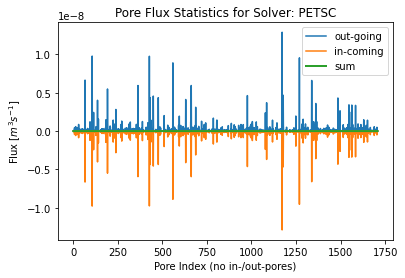

In [10]:
from mpi4py import MPI

from netflow import *  # netflow python library

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('netflow/')  # path to shared library

def plot_flux(inpores, outpores, p, Q):
    Qb = netflow.flux_balance(p, Q)
    
    # Exclude in- and out-pores respectively
    Qb = {pore: Qb[pore] for pore in Qb if (pore not in inpores) and (pore not in outpores)}
    x  = np.arange(len(Qb))
    
    Qp = np.array( [Qb[k][0] for k in Qb] )
    Qm = np.array( [Qb[k][1] for k in Qb] )
    Qs = np.array( [Qb[k][2] for k in Qb] )
    
    plt.figure()
    plt.title(r"Pore Flux Statistics for Solver: PETSC")
    plt.xlabel(r"Pore Index (no in-/out-pores)")
    plt.ylabel(r"Flux [$m^3s^{-1}$]")
    plt.plot(x, Qp, label=r"out-going")
    plt.plot(x, Qm, label=r"in-coming")
    plt.plot(x, Qs, label=r"sum", linewidth=2)
    plt.legend()
    plt.show()
    plt.close()
    
basenet = None
inpores  = set()
outpores = set()
    
# Initialization on root only
if (rank == root):
    # Load base network and compute set of in- and out-pores
    basenet = netflow.load_network_from('network/network.h5')
    for pore in basenet.pores:
        if pore.label[:2] == 'in':
            inpores.add(pore)
        elif pore.label[:3] == 'out':
            outpores.add(pore)
        
print("Pores: %d In-pores: %d Out-pores: %d" % (len(basenet.pores), \
                                                          len(inpores), \
                                                            len(outpores)))
    
# Compute solution and plot flux balances
start = MPI.Wtime()
p, Q = netflow.solve_flow_inout(network=basenet, pin=1e4, \
            pout=0.0, inpores=inpores, outpores=outpores, \
                solver=netflow.Solver.PETSC, mu=1e-3)
end = MPI.Wtime()

if rank == root:
    print("Time: %e s" % (end - start))
            
    plot_flux(inpores, outpores, p, Q)

## Network Generation
Here, we focus on the dendrogram-based parallel network generation method, called generate_dendrogram().

We use $4$ threads to generate a network that is twice as large in the first spatial direction, and the same size in the remaining two directions.

At the end, we plot the generated network and print the number of pores/throats.

Using 4 thread(s)
Network statistics:
Max. number of throats per pore: 44
Min. number of throats per pore: 1
Avg. number of throats per pore: 3.255690

Target size: [2, 1, 1]
distributing pores...
left 9 of 3435 clusters (incl. 1718 pores) untouched

connecting
Total throats: 7664
Throats left: 7664 Throats unrealized: 7664 (100.00%)
computing best matches
Throats left: 1424 Throats unrealized: 1424 (18.58%)
computing best matches
Throats left: 318 Throats unrealized: 318 (4.15%)
computing best matches
Throats left: 72 Throats unrealized: 72 (0.94%)
computing best matches
Throats left: 13 Throats unrealized: 13 (0.17%)
computing best matches
Throats left: 3 Throats unrealized: 4 (0.05%)

Searching serially...
progress 0.27662 throats in total, 2 unrealised (0.026%)
Avg. throat length difference: 9.012698e-06
Relative to Lmax: 1.584%
Elapsed time: 2.511573e+01 s


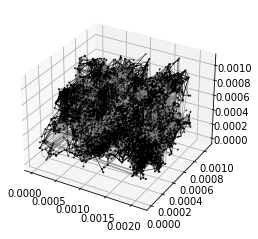


Generated network statistics:
Throats: 7662
Pores:   3436


In [14]:
from netflow import *

import matplotlib.pyplot as plt
from time import perf_counter
        
def main():
    nthreads = 4
    
    # Print statistics of base network used
    print("Using %d thread(s)" % nthreads)
    basenet = netflow.load_network_from('network/network.h5')
    print("Network statistics:")
    pore_throat_counts = [len(pore.throats) for pore in basenet.pores]
    print("Max. number of throats per pore: %d" % max(pore_throat_counts))
    print("Min. number of throats per pore: %d" % min(pore_throat_counts))
    print("Avg. number of throats per pore: %f" % (sum(pore_throat_counts) / len(pore_throat_counts)))
    print("")
    
    del pore_throat_counts
    
    # Generated network shall be twice as large in first direction
    target  = [2, 1, 1]
    print("Target size: {}".format(target))
    # Recommended cutoff: Half of largest dimension present in base network
    cutoff  = 0.5 * max([basenet.ub[i] - basenet.lb[i] \
                        for i in range(len(basenet.ub))])
    
    # Generate network using 4 threads
    start = perf_counter()
    dendro = netflow.generate_dendrogram(basenet=basenet, targetsize=target, \
                                        cutoff=cutoff, sd=42, nthreads=nthreads, \
                                        mute=False)
    end = perf_counter()
    elapsed = end - start
    print("Elapsed time: %e s" % elapsed)
    
    # Plot network (optional)
    _ = netgen.plot_network(dendro)
    plt.show()
        
    print("\nGenerated network statistics:")
    print("Throats: %d" % len(dendro.throats))
    print("Pores:   %d" % len(dendro.pores))
    
if __name__ == '__main__':
    main()